# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights

In [1]:
import os
os.chdir(os.getcwd() + '/..')

# Run some setup code for this notebook
import random
import numpy as np
import matplotlib.pyplot as plt

from utils.data_utils import load_CIFAR10

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data
cifar10_dir = 'datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

('Training data shape: ', (50000, 32, 32, 3))
('Training labels shape: ', (50000,))
('Test data shape: ', (10000, 32, 32, 3))
('Test labels shape: ', (10000,))


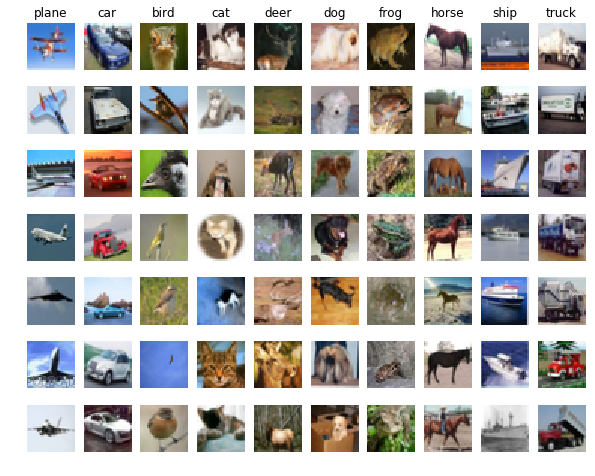

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y == y_train)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

mask = range(num_training, num_training+num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

('Train data shape: ', (49000, 32, 32, 3))
('Train labels shape: ', (49000,))
('Validation data shape: ', (1000, 32, 32, 3))
('Validation labels shape: ', (1000,))
('Test data shape: ', (10000, 32, 32, 3))
('Test labels shape: ', (10000,))


In [5]:
# Preprocessing: reshape the image data into rows
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_dev = X_dev.reshape(X_dev.shape[0], -1)

print('Train data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)

('Train data shape: ', (49000, 3072))
('Validation data shape: ', (1000, 3072))
('Test data shape: ', (10000, 3072))


[ 130.64189796  135.98173469  132.47391837  130.05569388  135.34804082
  131.75402041  130.96055102  136.14328571  132.47636735  131.48467347]


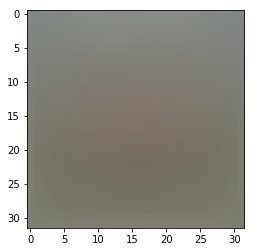

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4, 4))
plt.imshow(mean_image.reshape((32, 32, 3)).astype('uint8'))
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# third: append the bias dimension of ones
X_train = np.hstack((X_train, np.ones((X_train.shape[0], 1))))
X_val = np.hstack((X_val, np.ones((X_val.shape[0], 1))))
X_test = np.hstack((X_test, np.ones((X_test.shape[0], 1))))
X_dev= np.hstack((X_dev, np.ones((X_dev.shape[0], 1))))

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

((49000, 3073), (1000, 3073), (10000, 3073), (500, 3073))


## SVM Classifier
As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [9]:
# Evaluate the naive implementation of the loss we provided for you:
from classifiers.linear_classifier import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.886622


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [13]:
# gradient check
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

from utils.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# with regularization
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 31.708931, analytic: 31.665018, relative error: 6.929235e-04
numerical: 3.434268, analytic: 3.363690, relative error: 1.038221e-02
numerical: -7.838858, analytic: -7.910351, relative error: 4.539504e-03
numerical: -25.844247, analytic: -25.844247, relative error: 7.495420e-12
numerical: -9.314090, analytic: -9.314090, relative error: 5.951892e-11
numerical: -0.074699, analytic: -0.074699, relative error: 4.455066e-09
numerical: -10.480384, analytic: -10.503969, relative error: 1.123928e-03
numerical: 15.209832, analytic: 15.209832, relative error: 5.008249e-12
numerical: 16.915087, analytic: 16.850207, relative error: 1.921507e-03
numerical: -9.213772, analytic: -9.213772, relative error: 1.692757e-11
numerical: -14.203157, analytic: -14.203157, relative error: 7.668967e-12
numerical: 7.287020, analytic: 7.287020, relative error: 3.448310e-12
numerical: 3.488843, analytic: 3.512756, relative error: 3.415385e-03
numerical: -12.691293, analytic: -12.691293, relative error: 5.5

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *the SVM loss function is not strictly speaking differentiable*

In [19]:
# implement the function svm_loss_vectorized
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from classifiers.linear_classifier import svm_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses and grad should match but your vectorized implementation should be much faster.
print('loss difference: %f' % (loss_naive - loss_vectorized))
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('grad difference: %f' % difference)

Naive loss: 8.886622e+00 computed in 0.143529s
Vectorized loss: 8.886622e+00 computed in 0.005836s
loss difference: 0.000000
grad difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [22]:
from classifiers.linear_classifier import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4, num_iters=1500, batch_size=200, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 787.538442
iteration 100 / 1500: loss 286.566963
iteration 200 / 1500: loss 107.566202
iteration 300 / 1500: loss 42.469764
iteration 400 / 1500: loss 18.506299
iteration 500 / 1500: loss 10.472140
iteration 600 / 1500: loss 7.081734
iteration 700 / 1500: loss 6.083330
iteration 800 / 1500: loss 5.714924
iteration 900 / 1500: loss 4.959899
iteration 1000 / 1500: loss 4.869550
iteration 1100 / 1500: loss 5.687866
iteration 1200 / 1500: loss 5.066957
iteration 1300 / 1500: loss 5.805578
iteration 1400 / 1500: loss 5.067867
That took 8.883992s


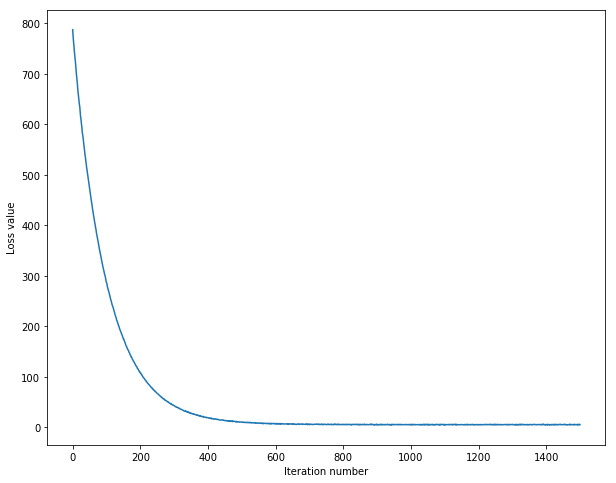

In [23]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [24]:
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred)))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred)))

training accuracy: 0.373490
validation accuracy: 0.385000


In [62]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate).
# accuracy of about 0.4 on the validation set
learning_rates = [7e-7, 8e-7, 9e-7]
regularization_strengths = [9e2, 1e3, 2e3]


# results[(learning_rate, reg)] = (train_accuracy, val_accuracy)
results = {}
best_val = -1
best_svm = None

for learning_rate in learning_rates:
    for reg in regularization_strengths:
        model = LinearSVM()
        model.train(X_train, y_train, learning_rate=learning_rate, reg=reg, num_iters=5000,
                   batch_size=300, verbose=True)
        y_train_pred = model.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = model.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)
        
        results[(learning_rate, reg)] = (train_accuracy, val_accuracy)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_svm = model
            
        print('lr %e reg %e train_accuracy: %f val_accuracy: %f' % (learning_rate, reg, train_accuracy, val_accuracy))
    print
    
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train_accuracy: %f val_accuracy: %f' % (lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 5000: loss 49.603126
iteration 100 / 5000: loss 28.577515
iteration 200 / 5000: loss 22.702602
iteration 300 / 5000: loss 18.257687
iteration 400 / 5000: loss 14.529571
iteration 500 / 5000: loss 12.508032
iteration 600 / 5000: loss 10.473361
iteration 700 / 5000: loss 8.949661
iteration 800 / 5000: loss 7.782215
iteration 900 / 5000: loss 7.485495
iteration 1000 / 5000: loss 7.001744
iteration 1100 / 5000: loss 6.956069
iteration 1200 / 5000: loss 5.809550
iteration 1300 / 5000: loss 6.099393
iteration 1400 / 5000: loss 5.225430
iteration 1500 / 5000: loss 5.668322
iteration 1600 / 5000: loss 4.529532
iteration 1700 / 5000: loss 5.629322
iteration 1800 / 5000: loss 4.795654
iteration 1900 / 5000: loss 5.156880
iteration 2000 / 5000: loss 5.340453
iteration 2100 / 5000: loss 4.233536
iteration 2200 / 5000: loss 4.248773
iteration 2300 / 5000: loss 4.399169
iteration 2400 / 5000: loss 4.877848
iteration 2500 / 5000: loss 4.563014
iteration 2600 / 5000: loss 4.944992
iterat

In [63]:
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train_accuracy: %f val_accuracy: %f' % (lr, reg, train_accuracy, val_accuracy))

lr 7.000000e-07 reg 9.000000e+02 train_accuracy: 0.393286 val_accuracy: 0.403000
lr 7.000000e-07 reg 1.000000e+03 train_accuracy: 0.401653 val_accuracy: 0.399000
lr 7.000000e-07 reg 2.000000e+03 train_accuracy: 0.358592 val_accuracy: 0.356000
lr 8.000000e-07 reg 9.000000e+02 train_accuracy: 0.393837 val_accuracy: 0.396000
lr 8.000000e-07 reg 1.000000e+03 train_accuracy: 0.357347 val_accuracy: 0.353000
lr 8.000000e-07 reg 2.000000e+03 train_accuracy: 0.376061 val_accuracy: 0.368000
lr 9.000000e-07 reg 9.000000e+02 train_accuracy: 0.374959 val_accuracy: 0.386000
lr 9.000000e-07 reg 1.000000e+03 train_accuracy: 0.374102 val_accuracy: 0.374000
lr 9.000000e-07 reg 2.000000e+03 train_accuracy: 0.370673 val_accuracy: 0.377000


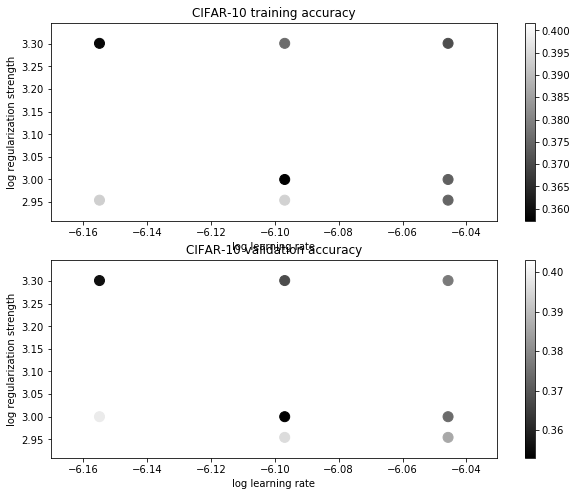

In [66]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results]
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')

plt.show()

In [67]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.373100


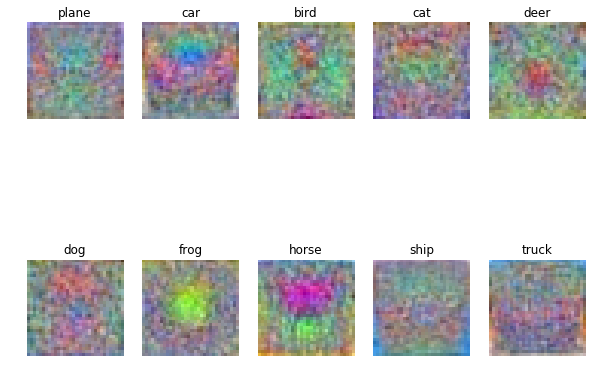

In [72]:
# Visualize the learned weights for each class.
w = best_svm.W[:-1, :] # STRIP OUT THE BIAS
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    #Rescale the weights to be between 0 and 255
    wing = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wing.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *templates*